# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [134]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.4.1'

#### Load Image Data

In [135]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 
NUM_FREEZE = 200

#### Generate Training and Validation Batches

In [136]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [137]:
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=2
)

In [138]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [139]:
print(f"Number of layers in the pretrained model: {len(pretrained.layers)}")

for i in range(NUM_FREEZE):
    pretrained.layers[i].trainable = False

Number of layers in the pretrained model: 311


In [140]:
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")

In [159]:
training_layers = tf.keras.Sequential([
    # add more layers
    tf.keras.layers.Conv2D(32,(3,3), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,(3,3), padding="same"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu')
])

In [160]:
inputs = tf.keras.Input(shape=(None, None, 3))
x = preprocess_input(inputs)
x = pretrained(x)
x = training_layers(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [143]:
inputs = tf.keras.Input(shape=(None, None, 3))
inputs.shape

TensorShape([None, None, None, 3])

In [161]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.math.truediv_33 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_33 (TFOpLam (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
sequential_27 (Sequential)   (None, 128)               806112    
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 129       
Total params: 22,609,025
Trainable params: 15,610,529
Non-trainable params: 6,998,496
_______________________________________

In [145]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### [5 points] Train Model

In [146]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_batches)

11
3
Epoch 1/40
11/11 [==============================] - 21s 1s/step - loss: 0.6993 - accuracy: 0.5367 - val_loss: 0.6925 - val_accuracy: 0.5385
Epoch 2/40
11/11 [==============================] - 12s 1s/step - loss: 0.6841 - accuracy: 0.5882 - val_loss: 0.6881 - val_accuracy: 0.5385
Epoch 3/40
11/11 [==============================] - 12s 1s/step - loss: 0.6874 - accuracy: 0.5590 - val_loss: 0.6888 - val_accuracy: 0.5385
Epoch 4/40
11/11 [==============================] - 12s 1s/step - loss: 0.6885 - accuracy: 0.5455 - val_loss: 0.6862 - val_accuracy: 0.5385
Epoch 5/40
11/11 [==============================] - 12s 1s/step - loss: 0.6657 - accuracy: 0.5760 - val_loss: 0.6819 - val_accuracy: 0.5385
Epoch 6/40
11/11 [==============================] - 12s 1s/step - loss: 0.6399 - accuracy: 0.6175 - val_loss: 0.6015 - val_accuracy: 0.8077
Epoch 7/40
11/11 [==============================] - 12s 1s/step - loss: 0.7294 - accuracy: 0.5419 - val_loss: 0.6483 - val_accuracy: 0.6538
Epoch 8/40
11/1

#### [5 points] Plot Accuracy and Loss During Training

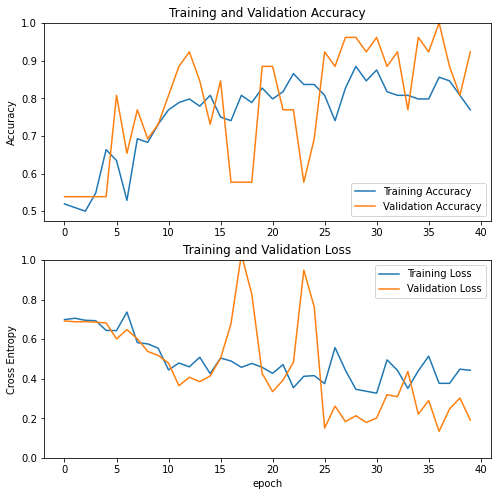

In [148]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Plot Test Results

Found 18 images belonging to 2 classes.


D:\Program Files\ANACONDA\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


18/18 [==============================] - 3s 79ms/step
covid\nejmoa2001191_f3-PA.jpeg


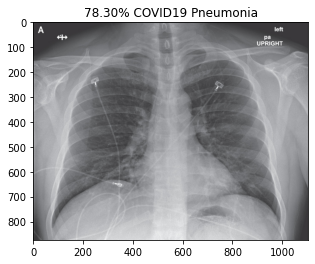

covid\nejmoa2001191_f4.jpeg


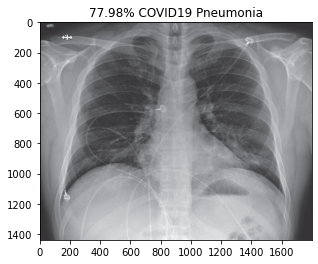

covid\nejmoa2001191_f5-PA.jpeg


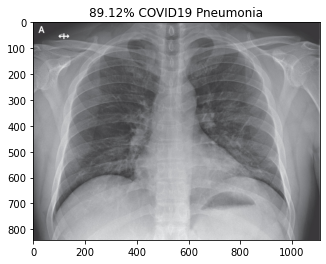

covid\radiol.2020200490.fig3.jpeg


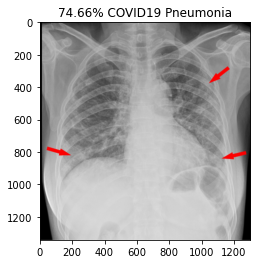

covid\ryct.2020200028.fig1a.jpeg


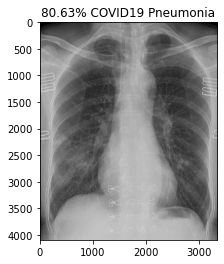

covid\ryct.2020200034.fig2.jpeg


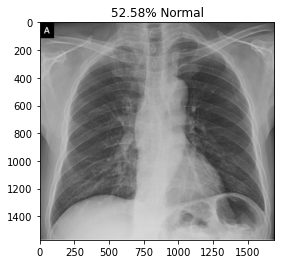

covid\ryct.2020200034.fig5-day0.jpeg


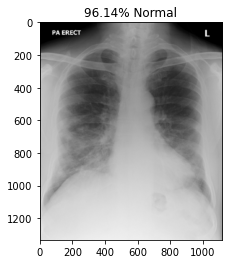

covid\ryct.2020200034.fig5-day4.jpeg


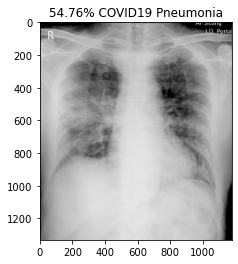

covid\ryct.2020200034.fig5-day7.jpeg


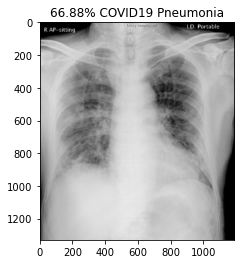

normal\NORMAL2-IM-1385-0001.jpeg


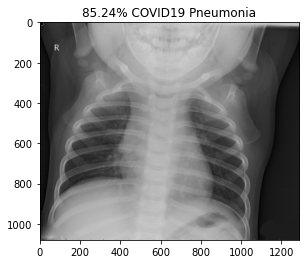

normal\NORMAL2-IM-1396-0001.jpeg


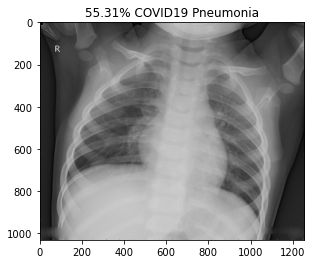

normal\NORMAL2-IM-1400-0001.jpeg


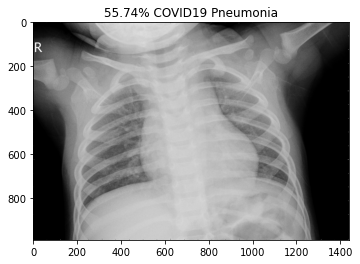

normal\NORMAL2-IM-1401-0001.jpeg


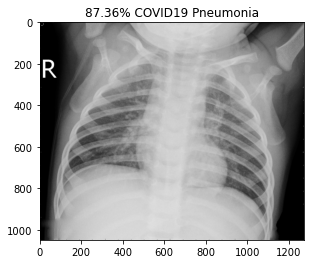

normal\NORMAL2-IM-1406-0001.jpeg


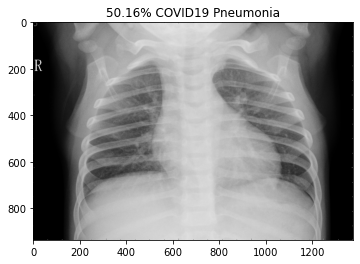

normal\NORMAL2-IM-1412-0001.jpeg


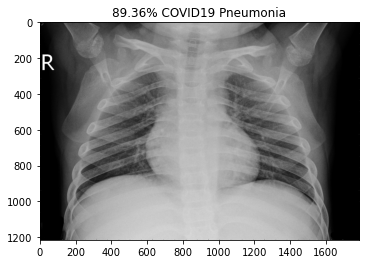

normal\NORMAL2-IM-1419-0001.jpeg


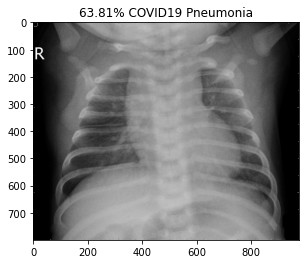

normal\NORMAL2-IM-1422-0001.jpeg


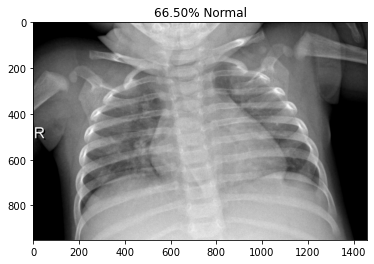

normal\NORMAL2-IM-1423-0001.jpeg


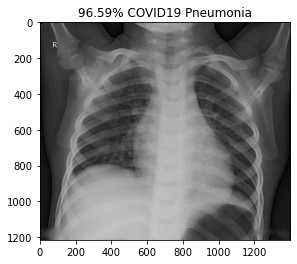

In [149]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [162]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_60').output)

tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                       batch_size=1,shuffle=False,seed=42,class_mode="binary")

intermediate_output = intermediate_layer_model.predict(tsne_data_generator)
#raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                          "and plot the resulting 2D features of the two classes.")
tsne = TSNE(n_components=2)
y = tsne.fit_transform(intermediate_output)




ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_43'), name='input_43', description="created by layer 'input_43'") at layer "tf.math.truediv_32". The following previous layers were accessed without issue: []

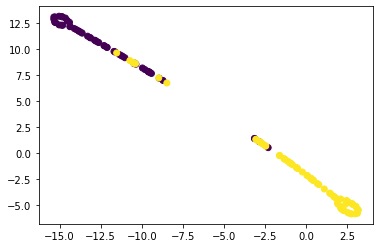

In [158]:
plt.scatter(y[:,0],y[:,1], c = tsne_data_generator.labels)

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->